In [4]:
pip install -q PySastrawi

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
import string

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from nltk.corpus import stopwords
from nltk import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
df = pd.read_csv('data.csv', encoding='latin-1') 
abusive = pd.read_csv('abusive.csv', encoding='latin-1') 
kamus =  pd.read_csv('new_kamusalay.csv', encoding='latin-1') 
sentiment = pd.read_csv("Clean_preprocess.tsv.txt",sep='\t')

In [7]:
print(sentiment)

                                                    Text    Respon
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
10995                                       tidak kecewa  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10997        hormati partai-partai yang telah berkoalisi   neutral
10998  pagi pagi di tol pasteur sudah macet parah , b...  negative
10999  meskipun sering belanja ke yogya di riau junct...  positive

[11000 rows x 2 columns]


In [8]:
sentiment.rename(columns = {0:'text', 1:'labels' }, inplace = True)
print(sentiment)

                                                    Text    Respon
0      warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1      mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2      lokasi strategis di jalan sumatera bandung . t...  positive
3      betapa bahagia nya diri ini saat unboxing pake...  positive
4      duh . jadi mahasiswa jangan sombong dong . kas...  negative
...                                                  ...       ...
10995                                       tidak kecewa  positive
10996  enak rasa masakan nya apalagi kepiting yang me...  positive
10997        hormati partai-partai yang telah berkoalisi   neutral
10998  pagi pagi di tol pasteur sudah macet parah , b...  negative
10999  meskipun sering belanja ke yogya di riau junct...  positive

[11000 rows x 2 columns]


In [9]:
punctuations = re.sub(r"[!<_>#:)\.]", "", string.punctuation)

def punct2wspace(text):
    return re.sub(r"[{}]+".format(punctuations), " ", text)

def normalize_wspace(text):
    return re.sub(r"\s+", " ", text)

def casefolding(text):
    return text.lower()

In [10]:
#clean stopwords
stopword = set(stopwords.words('indonesian'))
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword) # hapus stopword dari kolom text
    return text

stopword_eng = set(stopwords.words('english'))
def clean_stopwords_eng(text):
    text = ' '.join(word for word in text.split() if word not in stopword_eng) # hapus stopword dari kolom text
    return text

In [11]:
def stemmingtokenization(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = word_tokenize(text)
    final = [stemmer.stem(tagged_word) for tagged_word in tokens]
    return " ".join(final)

In [12]:
def preprocess_text(text):
    text = punct2wspace(text)
    text = normalize_wspace(text)
    text = casefolding(text)
    text = stemmingtokenization(text)
    text = clean_stopwords(text)
    text = clean_stopwords_eng(text)
    #text = final(text)
    return text

In [13]:
#import re
#def cleansing(text):
 # text = text.lower()
  #text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
  #return text

In [14]:

#make function to clean text and make a new "clean_text" column
#import re
#def cleansing(text):
#  text = text.lower()
#  text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
#  return text
sentiment['clean_text'] = sentiment.Text.apply(preprocess_text)

In [15]:
sentiment.head(5)

,Text,Respon,clean_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung milik usaha pabrik puluh kenal putih ba...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k212 mmbri hujjah partai diw...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nya ny...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh mahasiswa sombong kasih kartu kuning ajar ...


In [16]:
g=[]

In [17]:
for i in sentiment['clean_text']:
    g.append(i)

In [18]:
len(g)

11000

In [19]:
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 403


In [20]:
#Tokenizing and save the preprocessing process to pickle file 
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
token = tokenizer.fit_on_texts(sentiment['clean_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(sentiment['clean_text'])

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)



Found 12836 unique tokens.
tokenizer.pickle has created!


In [21]:
X = pad_sequences(X)
with open('sentiment.csv', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequencesv2.pickle has created!")

x_pad_sequencesv2.pickle has created!


In [22]:
#Convert Data target labels(text) to number  
Y = pd.get_dummies(sentiment['Respon'])
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [23]:
#train and Split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size=0.1, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9900, 78) (9900, 3)
(1100, 78) (1100, 3)


In [25]:
#Cross validate and train the data 
#For this one i use KFold
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Flatten
from tensorflow.keras import optimizers

kf = KFold(n_splits=4,random_state=42,shuffle=True) 

accuracies = []

y = Y

embed_dim = 100
units = 100

for iteration, data in enumerate(kf.split(X), start=1):

    #Splitting the data
    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    #Making deep learning model sequwential
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))

    adam = optimizers.Adam(lr = 0.0001)
    # Tentukan loss, optimizer dan metrik yang akan digunakan
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    #Earlystop
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #Training the model 
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, validation_data=(data_test, target_test), verbose=1,shuffle=True, callbacks=[es])
    #Predict the model 
    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

Epoch 1/50
258/258 [==============================] - 45s 167ms/step - loss: 0.5589 - accuracy: 0.7755 - val_loss: 0.4181 - val_accuracy: 0.8324
Epoch 2/50
258/258 [==============================] - 41s 159ms/step - loss: 0.2637 - accuracy: 0.9062 - val_loss: 0.4160 - val_accuracy: 0.8349
Epoch 3/50
258/258 [==============================] - 41s 158ms/step - loss: 0.1644 - accuracy: 0.9425 - val_loss: 0.4675 - val_accuracy: 0.8342
Epoch 4/50
258/258 [==============================] - 43s 165ms/step - loss: 0.1119 - accuracy: 0.9593 - val_loss: 0.5079 - val_accuracy: 0.8309
Epoch 5/50
258/258 [==============================] - 41s 159ms/step - loss: 0.0800 - accuracy: 0.9696 - val_loss: 0.6413 - val_accuracy: 0.8276
Epoch 5: early stopping
35/35 [==============================] - 1s 21ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       343
           1       0.94      0.94      0.94       115
           2       

Epoch 1/50
258/258 [==============================] - 44s 158ms/step - loss: 0.5787 - accuracy: 0.7672 - val_loss: 0.4331 - val_accuracy: 0.8316
Epoch 2/50
258/258 [==============================] - 42s 163ms/step - loss: 0.2765 - accuracy: 0.8985 - val_loss: 0.3979 - val_accuracy: 0.8462
Epoch 3/50
258/258 [==============================] - 42s 163ms/step - loss: 0.1656 - accuracy: 0.9423 - val_loss: 0.4578 - val_accuracy: 0.8320
Epoch 4/50
258/258 [==============================] - 42s 162ms/step - loss: 0.1074 - accuracy: 0.9602 - val_loss: 0.5608 - val_accuracy: 0.8331
Epoch 5/50
258/258 [==============================] - 45s 175ms/step - loss: 0.0785 - accuracy: 0.9710 - val_loss: 0.6012 - val_accuracy: 0.8287
Epoch 5: early stopping
35/35 [==============================] - 1s 19ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       343
           1       0.96      0.90      0.93       115
           2       

Epoch 1/50
258/258 [==============================] - 49s 179ms/step - loss: 0.5678 - accuracy: 0.7636 - val_loss: 0.4010 - val_accuracy: 0.8436
Epoch 2/50
258/258 [==============================] - 45s 176ms/step - loss: 0.2709 - accuracy: 0.9017 - val_loss: 0.4049 - val_accuracy: 0.8520
Epoch 3/50
258/258 [==============================] - 45s 175ms/step - loss: 0.1635 - accuracy: 0.9421 - val_loss: 0.4311 - val_accuracy: 0.8415
Epoch 4/50
258/258 [==============================] - 46s 177ms/step - loss: 0.1109 - accuracy: 0.9583 - val_loss: 0.5520 - val_accuracy: 0.8313
Epoch 4: early stopping
35/35 [==============================] - 1s 23ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       343
           1       0.97      0.87      0.92       115
           2       0.94      0.98      0.96       642

    accuracy                           0.94      1100
   macro avg       0.95      0.91      0.93      1100
w

Epoch 1/50
258/258 [==============================] - 50s 181ms/step - loss: 0.5676 - accuracy: 0.7646 - val_loss: 0.3774 - val_accuracy: 0.8553
Epoch 2/50
258/258 [==============================] - 45s 174ms/step - loss: 0.2812 - accuracy: 0.8947 - val_loss: 0.3691 - val_accuracy: 0.8607
Epoch 3/50
258/258 [==============================] - 45s 175ms/step - loss: 0.1670 - accuracy: 0.9372 - val_loss: 0.4176 - val_accuracy: 0.8571
Epoch 4/50
258/258 [==============================] - 46s 180ms/step - loss: 0.1221 - accuracy: 0.9542 - val_loss: 0.4702 - val_accuracy: 0.8280
Epoch 5/50
258/258 [==============================] - 46s 178ms/step - loss: 0.0902 - accuracy: 0.9655 - val_loss: 0.5582 - val_accuracy: 0.8302
Epoch 5: early stopping
35/35 [==============================] - 1s 23ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       343
           1       0.89      0.90      0.90       115
           2       

In [26]:
import keras

# Melihat Diagram Model
keras.utils.vis_utils.plot_model(model, "model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


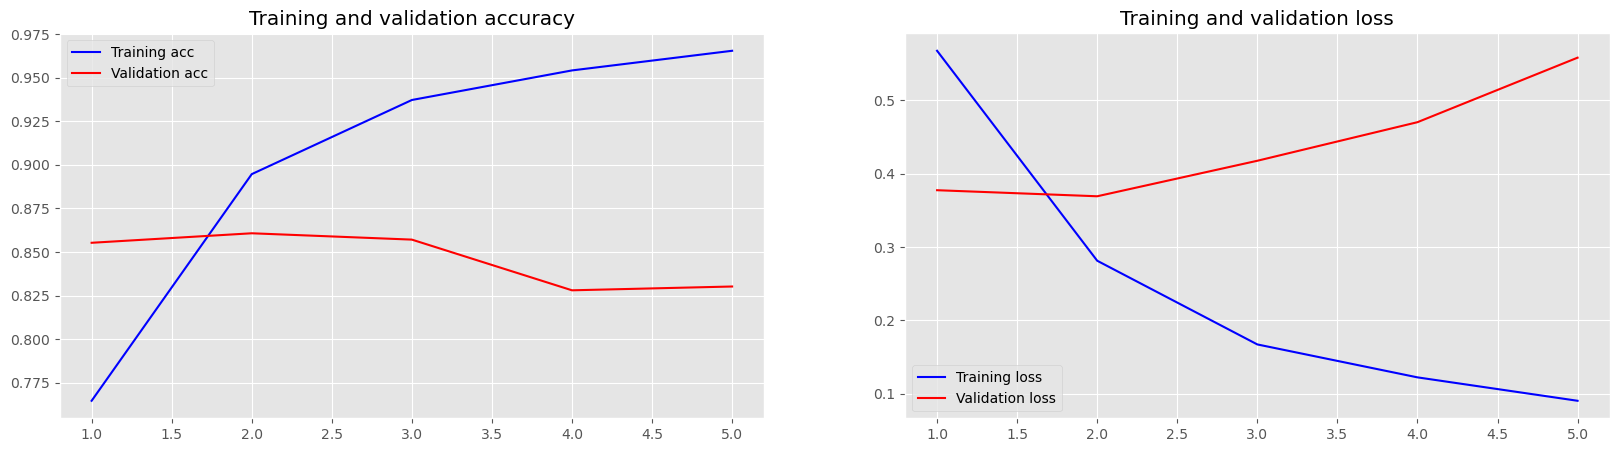

In [28]:
# Visualize the data 
# history.history to see the history of the deep learning model like accuracy and lose 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [29]:
#save the model
model.save('mymodel.h5')
print("Model has created!")

Model has created!


In [30]:
# model evaluation
from keras.models import load_model

model = load_model('mymodel.h5')
scores = model.evaluate(X_test, y_test)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

35/35 [==============================] - 1s 19ms/step - loss: 0.1859 - accuracy: 0.9400
Test accuracy:  93.99999976158142 %


In [31]:
#A function for predict the sentiment
import re 
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

input_text = """makanan di sini tidak enak"""
input_text2 = """makanan di sini gak enak"""
input_text3 = """makanan di sini engga enak"""
input_text4 = """makanan di sini kurang enak"""
input_text5 = """presiden indonesia keren sekali"""
input_text6 = """presiden indonesia pergi ke timur tengah"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text5)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('mymodel.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 394ms/step
Text: presiden indonesia keren sekali
Sentiment: positive
